In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import imageio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

In [3]:
print(torch.__version__)
torch.cuda.is_available()

1.13.1+cu117


True

In [4]:
#utils

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('../outputs/generated_images.gif', imgs)
    
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"../outputs/output{epoch}.jpg")
    
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../outputs/loss.jpg')
    plt.show()

In [5]:
#engine

def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [6]:
#model

kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling


# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [8]:
#train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = ConvVAE().to(device)

# set the learning parameters
lr = 0.001
epochs = 100
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []



In [9]:
#train prepare data

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../../../data', train=True, download=True, transform=transform
)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)

# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../../../data', train=False, download=True, transform=transform
)

testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

Epoch 1 of 100


938it [00:13, 69.09it/s]                                                        
157it [00:01, 114.13it/s]                                                       


Train Loss: 15294.7573
Val Loss: 11750.0632
Epoch 2 of 100


938it [00:11, 79.20it/s]                                                        
157it [00:01, 111.87it/s]                                                       


Train Loss: 11284.1603
Val Loss: 10841.1668
Epoch 3 of 100


938it [00:12, 75.44it/s]                                                        
157it [00:01, 108.15it/s]                                                       


Train Loss: 10811.9497
Val Loss: 10624.3175
Epoch 4 of 100


938it [00:11, 79.50it/s]                                                        
157it [00:01, 112.89it/s]                                                       


Train Loss: 10642.4642
Val Loss: 10525.7748
Epoch 5 of 100


938it [00:11, 79.33it/s]                                                        
157it [00:01, 113.07it/s]                                                       


Train Loss: 10535.8094
Val Loss: 10403.1404
Epoch 6 of 100


938it [00:12, 75.79it/s]                                                        
157it [00:01, 114.88it/s]                                                       


Train Loss: 10463.4268
Val Loss: 10366.7595
Epoch 7 of 100


938it [00:11, 79.34it/s]                                                        
157it [00:01, 102.87it/s]                                                       


Train Loss: 10383.6423
Val Loss: 10261.2399
Epoch 8 of 100


938it [00:11, 78.99it/s]                                                        
157it [00:01, 109.84it/s]                                                       


Train Loss: 10215.1821
Val Loss: 10071.6257
Epoch 9 of 100


938it [00:12, 76.61it/s]                                                        
157it [00:01, 113.16it/s]                                                       


Train Loss: 10125.7482
Val Loss: 10089.0370
Epoch 10 of 100


938it [00:11, 79.36it/s]                                                        
157it [00:01, 115.27it/s]                                                       


Train Loss: 10077.3317
Val Loss: 10022.7897
Epoch 11 of 100


938it [00:12, 75.22it/s]                                                        
157it [00:01, 112.61it/s]                                                       


Train Loss: 10041.7110
Val Loss: 9947.6713
Epoch 12 of 100


938it [00:11, 80.24it/s]                                                        
157it [00:01, 114.29it/s]                                                       


Train Loss: 10004.1519
Val Loss: 10030.3619
Epoch 13 of 100


938it [00:12, 75.94it/s]                                                        
157it [00:01, 110.66it/s]                                                       


Train Loss: 9982.5065
Val Loss: 9919.0475
Epoch 14 of 100


938it [00:12, 75.93it/s]                                                        
157it [00:01, 105.10it/s]                                                       


Train Loss: 9959.3199
Val Loss: 9911.9096
Epoch 15 of 100


938it [00:12, 76.50it/s]                                                        
157it [00:01, 112.83it/s]                                                       


Train Loss: 9911.1840
Val Loss: 9871.7424
Epoch 16 of 100


938it [00:11, 78.46it/s]                                                        
157it [00:01, 112.47it/s]                                                       


Train Loss: 9866.3739
Val Loss: 9843.7712
Epoch 17 of 100


938it [00:12, 76.71it/s]                                                        
157it [00:01, 109.69it/s]                                                       


Train Loss: 9832.8608
Val Loss: 9788.5406
Epoch 18 of 100


938it [00:12, 77.08it/s]                                                        
157it [00:01, 113.16it/s]                                                       


Train Loss: 9792.0601
Val Loss: 9753.0943
Epoch 19 of 100


938it [00:12, 77.23it/s]                                                        
157it [00:01, 113.16it/s]                                                       


Train Loss: 9767.9286
Val Loss: 9727.4020
Epoch 20 of 100


938it [00:11, 78.70it/s]                                                        
157it [00:01, 114.34it/s]                                                       


Train Loss: 9748.3226
Val Loss: 9745.7609
Epoch 21 of 100


938it [00:12, 77.80it/s]                                                        
157it [00:01, 107.86it/s]                                                       


Train Loss: 9736.3455
Val Loss: 9712.0960
Epoch 22 of 100


938it [00:11, 78.23it/s]                                                        
157it [00:01, 113.54it/s]                                                       


Train Loss: 9721.5643
Val Loss: 9682.2157
Epoch 23 of 100


938it [00:12, 76.11it/s]                                                        
157it [00:01, 111.22it/s]                                                       


Train Loss: 9713.2791
Val Loss: 9669.8768
Epoch 24 of 100


938it [00:12, 77.86it/s]                                                        
157it [00:01, 111.78it/s]                                                       


Train Loss: 9699.0784
Val Loss: 9693.7252
Epoch 25 of 100


938it [00:11, 78.24it/s]                                                        
157it [00:01, 111.45it/s]                                                       


Train Loss: 9691.0557
Val Loss: 9661.6282
Epoch 26 of 100


938it [00:12, 77.22it/s]                                                        
157it [00:01, 112.06it/s]                                                       


Train Loss: 9681.3058
Val Loss: 9639.6222
Epoch 27 of 100


938it [00:11, 78.90it/s]                                                        
157it [00:01, 112.17it/s]                                                       


Train Loss: 9668.2863
Val Loss: 9700.3659
Epoch 28 of 100


938it [00:11, 78.83it/s]                                                        
157it [00:01, 111.76it/s]                                                       


Train Loss: 9659.9107
Val Loss: 9635.3319
Epoch 29 of 100


938it [00:12, 77.90it/s]                                                        
157it [00:01, 108.57it/s]                                                       


Train Loss: 9655.3595
Val Loss: 9657.0349
Epoch 30 of 100


938it [00:12, 78.08it/s]                                                        
157it [00:01, 111.29it/s]                                                       


Train Loss: 9649.5953
Val Loss: 9601.9491
Epoch 31 of 100


938it [00:12, 75.11it/s]                                                        
157it [00:01, 105.40it/s]                                                       


Train Loss: 9643.9882
Val Loss: 9651.1050
Epoch 32 of 100


938it [00:12, 77.87it/s]                                                        
157it [00:01, 112.01it/s]                                                       


Train Loss: 9634.9906
Val Loss: 9636.6748
Epoch 33 of 100


938it [00:12, 75.80it/s]                                                        
157it [00:01, 108.67it/s]                                                       


Train Loss: 9628.7464
Val Loss: 9642.1216
Epoch 34 of 100


938it [00:12, 77.88it/s]                                                        
157it [00:01, 111.25it/s]                                                       


Train Loss: 9620.9613
Val Loss: 9613.5407
Epoch 35 of 100


938it [00:11, 80.02it/s]                                                        
157it [00:01, 113.27it/s]                                                       


Train Loss: 9615.3852
Val Loss: 9608.6059
Epoch 36 of 100


938it [00:11, 79.35it/s]                                                        
157it [00:01, 112.20it/s]                                                       


Train Loss: 9611.2028
Val Loss: 9609.7070
Epoch 37 of 100


938it [00:11, 78.31it/s]                                                        
157it [00:01, 113.35it/s]                                                       


Train Loss: 9603.8996
Val Loss: 9575.8591
Epoch 38 of 100


938it [00:11, 80.78it/s]                                                        
157it [00:01, 115.85it/s]                                                       


Train Loss: 9599.6656
Val Loss: 9599.5577
Epoch 39 of 100


938it [00:11, 79.53it/s]                                                        
157it [00:01, 113.40it/s]                                                       


Train Loss: 9595.2534
Val Loss: 9592.7857
Epoch 40 of 100


938it [00:12, 74.37it/s]                                                        
157it [00:01, 109.65it/s]                                                       


Train Loss: 9592.4263
Val Loss: 9612.4344
Epoch 41 of 100


938it [00:11, 80.34it/s]                                                        
157it [00:01, 116.18it/s]                                                       


Train Loss: 9586.9742
Val Loss: 9675.9022
Epoch 42 of 100


938it [00:11, 79.57it/s]                                                        
157it [00:01, 116.31it/s]                                                       


Train Loss: 9582.3076
Val Loss: 9564.6793
Epoch 43 of 100


938it [00:11, 79.20it/s]                                                        
157it [00:01, 113.41it/s]                                                       


Train Loss: 9575.2011
Val Loss: 9557.4734
Epoch 44 of 100


938it [00:11, 78.65it/s]                                                        
157it [00:01, 109.54it/s]                                                       


Train Loss: 9572.3906
Val Loss: 9560.9288
Epoch 45 of 100


938it [00:11, 81.02it/s]                                                        
157it [00:01, 116.18it/s]                                                       


Train Loss: 9570.2634
Val Loss: 9561.4581
Epoch 46 of 100


938it [00:11, 81.09it/s]                                                        
157it [00:01, 116.39it/s]                                                       


Train Loss: 9567.1657
Val Loss: 9550.0016
Epoch 47 of 100


938it [00:11, 81.14it/s]                                                        
157it [00:01, 116.03it/s]                                                       


Train Loss: 9561.2714
Val Loss: 9572.6549
Epoch 48 of 100


938it [00:11, 79.57it/s]                                                        
157it [00:01, 115.48it/s]                                                       


Train Loss: 9559.0708
Val Loss: 9559.3739
Epoch 49 of 100


938it [00:11, 79.43it/s]                                                        
157it [00:01, 113.72it/s]                                                       


Train Loss: 9554.6437
Val Loss: 9594.8210
Epoch 50 of 100


938it [00:11, 79.17it/s]                                                        
157it [00:01, 113.79it/s]                                                       


Train Loss: 9551.9929
Val Loss: 9590.1636
Epoch 51 of 100


938it [00:11, 79.03it/s]                                                        
157it [00:01, 112.77it/s]                                                       


Train Loss: 9549.8236
Val Loss: 9548.6542
Epoch 52 of 100


938it [00:11, 79.09it/s]                                                        
157it [00:01, 113.53it/s]                                                       


Train Loss: 9544.2974
Val Loss: 9550.5375
Epoch 53 of 100


938it [00:12, 78.14it/s]                                                        
157it [00:01, 116.32it/s]                                                       


Train Loss: 9543.2765
Val Loss: 9543.0754
Epoch 54 of 100


938it [00:11, 78.66it/s]                                                        
157it [00:01, 111.93it/s]                                                       


Train Loss: 9542.9512
Val Loss: 9541.8350
Epoch 55 of 100


938it [00:11, 78.62it/s]                                                        
157it [00:01, 112.41it/s]                                                       


Train Loss: 9536.5119
Val Loss: 9549.1618
Epoch 56 of 100


938it [00:11, 80.23it/s]                                                        
157it [00:01, 112.22it/s]                                                       


Train Loss: 9534.7711
Val Loss: 9559.3194
Epoch 57 of 100


938it [00:11, 79.01it/s]                                                        
157it [00:01, 113.01it/s]                                                       


Train Loss: 9530.6276
Val Loss: 9531.9563
Epoch 58 of 100


938it [00:11, 79.10it/s]                                                        
157it [00:01, 112.38it/s]                                                       


Train Loss: 9532.2957
Val Loss: 9564.6493
Epoch 59 of 100


938it [00:11, 79.22it/s]                                                        
157it [00:01, 113.56it/s]                                                       


Train Loss: 9527.4889
Val Loss: 9536.5143
Epoch 60 of 100


938it [00:11, 78.94it/s]                                                        
157it [00:01, 112.33it/s]                                                       


Train Loss: 9523.8982
Val Loss: 9577.3457
Epoch 61 of 100


938it [00:11, 78.78it/s]                                                        
157it [00:01, 112.94it/s]                                                       


Train Loss: 9524.6467
Val Loss: 9567.4912
Epoch 62 of 100


938it [00:11, 79.18it/s]                                                        
157it [00:01, 113.84it/s]                                                       


Train Loss: 9520.5374
Val Loss: 9504.2871
Epoch 63 of 100


938it [00:11, 79.22it/s]                                                        
157it [00:01, 113.83it/s]                                                       


Train Loss: 9518.5524
Val Loss: 9533.9834
Epoch 64 of 100


938it [00:11, 79.62it/s]                                                        
157it [00:01, 112.18it/s]                                                       


Train Loss: 9514.9520
Val Loss: 9553.2105
Epoch 65 of 100


938it [00:11, 79.68it/s]                                                        
157it [00:01, 114.95it/s]                                                       


Train Loss: 9515.1955
Val Loss: 9537.3884
Epoch 66 of 100


938it [00:11, 78.76it/s]                                                        
157it [00:01, 112.58it/s]                                                       


Train Loss: 9509.8250
Val Loss: 9510.8001
Epoch 67 of 100


938it [00:11, 80.01it/s]                                                        
157it [00:01, 114.48it/s]                                                       


Train Loss: 9508.9972
Val Loss: 9520.8500
Epoch 68 of 100


938it [00:11, 79.44it/s]                                                        
157it [00:01, 113.18it/s]                                                       


Train Loss: 9508.3538
Val Loss: 9563.3112
Epoch 69 of 100


938it [00:11, 79.85it/s]                                                        
157it [00:01, 114.66it/s]                                                       


Train Loss: 9507.7822
Val Loss: 9500.5448
Epoch 70 of 100


938it [00:11, 79.19it/s]                                                        
157it [00:01, 113.76it/s]                                                       


Train Loss: 9503.6105
Val Loss: 9528.1174
Epoch 71 of 100


938it [00:11, 79.48it/s]                                                        
157it [00:01, 113.91it/s]                                                       


Train Loss: 9501.1453
Val Loss: 9527.1248
Epoch 72 of 100


938it [00:11, 79.86it/s]                                                        
157it [00:01, 115.58it/s]                                                       


Train Loss: 9500.3890
Val Loss: 9517.8482
Epoch 73 of 100


938it [00:11, 80.20it/s]                                                        
157it [00:01, 115.75it/s]                                                       


Train Loss: 9497.0001
Val Loss: 9508.4792
Epoch 74 of 100


938it [00:11, 81.13it/s]                                                        
157it [00:01, 116.10it/s]                                                       


Train Loss: 9494.9788
Val Loss: 9543.5461
Epoch 75 of 100


938it [00:11, 79.04it/s]                                                        
157it [00:01, 113.26it/s]                                                       


Train Loss: 9494.4086
Val Loss: 9546.9949
Epoch 76 of 100


938it [00:11, 79.13it/s]                                                        
157it [00:01, 112.77it/s]                                                       


Train Loss: 9492.1854
Val Loss: 9506.7056
Epoch 77 of 100


938it [00:11, 80.94it/s]                                                        
157it [00:01, 115.50it/s]                                                       


Train Loss: 9493.8354
Val Loss: 9520.5699
Epoch 78 of 100


938it [00:11, 79.81it/s]                                                        
157it [00:01, 114.39it/s]                                                       


Train Loss: 9492.4972
Val Loss: 9517.9545
Epoch 79 of 100


938it [00:11, 80.02it/s]                                                        
157it [00:01, 114.37it/s]                                                       


Train Loss: 9486.8742
Val Loss: 9518.9798
Epoch 80 of 100


938it [00:11, 79.88it/s]                                                        
157it [00:01, 112.94it/s]                                                       


Train Loss: 9486.6495
Val Loss: 9494.6325
Epoch 81 of 100


938it [00:11, 80.57it/s]                                                        
157it [00:01, 113.89it/s]                                                       


Train Loss: 9484.2382
Val Loss: 9541.2878
Epoch 82 of 100


938it [00:11, 78.37it/s]                                                        
157it [00:01, 111.40it/s]                                                       


Train Loss: 9483.3873
Val Loss: 9507.2689
Epoch 83 of 100


938it [00:11, 78.33it/s]                                                        
157it [00:01, 111.53it/s]                                                       


Train Loss: 9483.7437
Val Loss: 9486.7201
Epoch 84 of 100


938it [00:11, 78.83it/s]                                                        
157it [00:01, 112.17it/s]                                                       


Train Loss: 9480.3843
Val Loss: 9505.3476
Epoch 85 of 100


938it [00:11, 79.06it/s]                                                        
157it [00:01, 112.08it/s]                                                       


Train Loss: 9479.3172
Val Loss: 9526.9723
Epoch 86 of 100


938it [00:11, 78.87it/s]                                                        
157it [00:01, 112.31it/s]                                                       


Train Loss: 9476.4203
Val Loss: 9506.6619
Epoch 87 of 100


938it [00:11, 79.51it/s]                                                        
157it [00:01, 114.63it/s]                                                       


Train Loss: 9476.8635
Val Loss: 9493.7161
Epoch 88 of 100


938it [00:11, 80.97it/s]                                                        
157it [00:01, 115.87it/s]                                                       


Train Loss: 9473.5228
Val Loss: 9511.9371
Epoch 89 of 100


938it [00:11, 80.14it/s]                                                        
157it [00:01, 113.23it/s]                                                       


Train Loss: 9473.5179
Val Loss: 9510.6222
Epoch 90 of 100


938it [00:11, 80.01it/s]                                                        
157it [00:01, 114.03it/s]                                                       


Train Loss: 9473.3926
Val Loss: 9482.1141
Epoch 91 of 100


938it [00:11, 80.03it/s]                                                        
157it [00:01, 114.66it/s]                                                       


Train Loss: 9472.2375
Val Loss: 9510.8229
Epoch 92 of 100


938it [00:11, 80.15it/s]                                                        
157it [00:01, 116.51it/s]                                                       


Train Loss: 9473.5155
Val Loss: 9495.6451
Epoch 93 of 100


938it [00:11, 81.03it/s]                                                        
157it [00:01, 116.89it/s]                                                       


Train Loss: 9469.2692
Val Loss: 9487.4329
Epoch 94 of 100


938it [00:11, 80.80it/s]                                                        
157it [00:01, 116.12it/s]                                                       


Train Loss: 9467.6195
Val Loss: 9519.1389
Epoch 95 of 100


938it [00:11, 80.76it/s]                                                        
157it [00:01, 114.28it/s]                                                       


Train Loss: 9466.5740
Val Loss: 9516.9655
Epoch 96 of 100


938it [00:11, 80.99it/s]                                                        
157it [00:01, 114.94it/s]                                                       


Train Loss: 9466.4646
Val Loss: 9552.3175
Epoch 97 of 100


938it [00:11, 80.86it/s]                                                        
157it [00:01, 115.67it/s]                                                       


Train Loss: 9464.6239
Val Loss: 9519.1089
Epoch 98 of 100


938it [00:11, 79.92it/s]                                                        
157it [00:01, 113.72it/s]                                                       


Train Loss: 9462.5943
Val Loss: 9503.9441
Epoch 99 of 100


938it [00:11, 78.71it/s]                                                        
157it [00:01, 112.12it/s]                                                       


Train Loss: 9459.8843
Val Loss: 9510.7944
Epoch 100 of 100


938it [00:11, 79.34it/s]                                                        
157it [00:01, 114.68it/s]                                                       


Train Loss: 9459.3053
Val Loss: 9526.0726


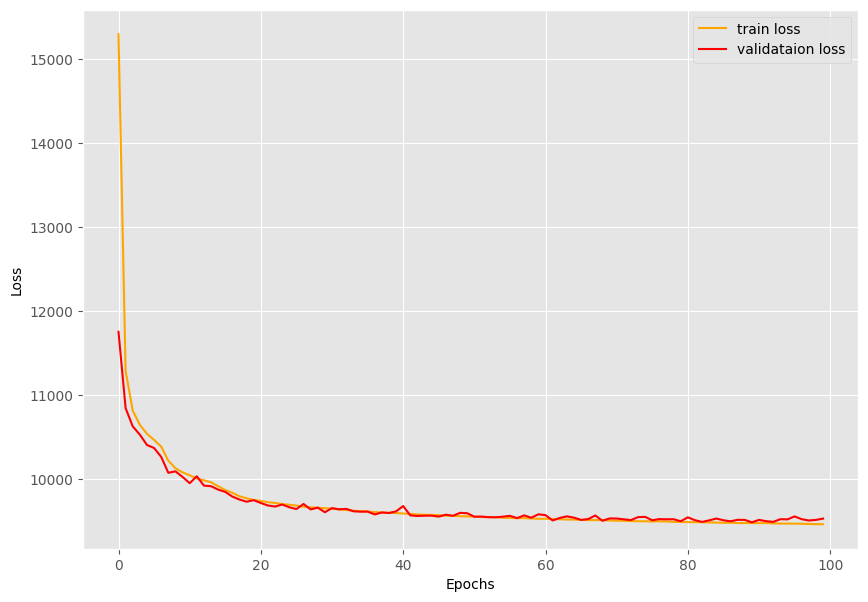

TRAINING COMPLETE


In [10]:
#train loop

train_loss = []
valid_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    
# save the reconstructions as a .gif file
image_to_vid(grid_images)

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)

print('TRAINING COMPLETE')